# Analyse des commentaires
Dans ce notebook, nous allons regarder en détail les commentaires laissés par les utilisateurs.
Le travail sera divisé en deux parties : Construction du corpus et Début ? d'analyse des fréquences

In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import NMF, Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from itertools import product
from scipy import sparse

from reco_systems.filter import filter_df
import reco_systems.evaluation_bigrams_func as ebf
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Data

In [2]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 20
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=np.arange(0, rev_filter.shape[0]))
rev_filter_center, _= center_score(rev_filter)

11201 10549
1300 1341
963 1221
925 1200
918 1198
917 1196
916 1192
913 1190


### Corpus 5000 mots

In [5]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
corpus = ebf.construction_corpus(lemmas, 5000) 
lemmas = lemmas[lemmas["Lemma"].isin(corpus)] # only words in corpus

# Joined lemmas
comments = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})

### NMF 20 latent factors

In [8]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]

### 30 KMeans games clusters 

In [9]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id" : np.sort(games_ids), "Cluster" : kmeans.labels_})

In [10]:
# Séparation de la bdd 
positifs = rev_filter_center[rev_filter_center['Rating'] >= 0]
negatifs = rev_filter_center[rev_filter_center['Rating'] < 0]

print("Nombre d'avis negatif", len(negatifs)/len(rev_filter_center))
print("Nombre d'avis positif", len(positifs)/len(rev_filter_center))

Nombre d'avis negatif 0.4353934363912823
Nombre d'avis positif 0.5646065636087176


In [11]:
lemmas_pos = positifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_neg = negatifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_pos = lemmas_pos.drop(["index"], axis=1)
lemmas_neg = lemmas_neg.drop(["index"], axis=1)

lemmas_all = rev_filter[["User id", "Game id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_all = lemmas_all.drop(["index"], axis=1)

In [12]:
comments_neg = lemmas_neg.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_neg = comments_neg.assign(pos_neg = "negative")

comments_pos = lemmas_pos.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_pos = comments_pos.assign(pos_neg = "positive")

comments_all = pd.concat([comments_neg, comments_pos])
comments_all_count = comments_all[["Game id", "pos_neg", "User id"]].groupby(["Game id", "pos_neg"]).count().rename(columns={"User id":"count"}).reset_index()

In [13]:
rev_neg_count = comments_neg["Game id"].value_counts().reset_index()
rev_pos_count = comments_pos["Game id"].value_counts().reset_index()

# Filter games so that each game has at least 10 pos and 10 neg reviews
games_preserved = rev_neg_count[rev_neg_count["Game id"].isin(rev_pos_count.loc[rev_pos_count["count"] >= 10, "Game id"])
                                & rev_neg_count["Game id"].isin(rev_neg_count.loc[rev_neg_count["count"] >= 10, "Game id"])]["Game id"].values
                                
mask = np.isin(np.sort(games_ids), games_preserved)

# Games clusters contains only games that were filtered
games_clusters = pd.DataFrame(data={"Game id":np.sort(games_ids)[mask], "Cluster":kmeans.labels_[mask]})

### Bigrams

### User recommendation KNN

In [14]:
# Init
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
top_users = rev_filter[["User id", "Rating"]].groupby("User id").count().reset_index().sort_values(by="Rating", ascending=False)["User id"].values

games_to_consider = games_clusters["Game id"].values

users_mean = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()

---

### Using tf idf to filter bigrams

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
# lemmatized comments
all_doc = comments_all['Lemma']
vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=5, max_df=0.8) # bigrams
vectors = vectorizer.fit_transform(all_doc)

In [16]:
bigrams_ens = vectorizer.get_feature_names_out()

In [17]:
comments_all = comments_all.drop(columns=['Comment line']).reset_index()
comments_all = comments_all.drop(columns=['index']).reset_index()

In [18]:
# plotting for the threshold
tfidf_value = vectors.data

---
---


Plots
---

In [20]:
# 200 users sampled randomly, mean on 5 itérations
# k = 40, users and games filtered with min reviews = 20, comment length > 10
# thresold for bigrames = 0.13
# 3 types of neighbors: similar, less similar, random
# Evaluation on well predicted games (diff < 2) 

#### Recall, intersection / user number of bigrams, using frequence

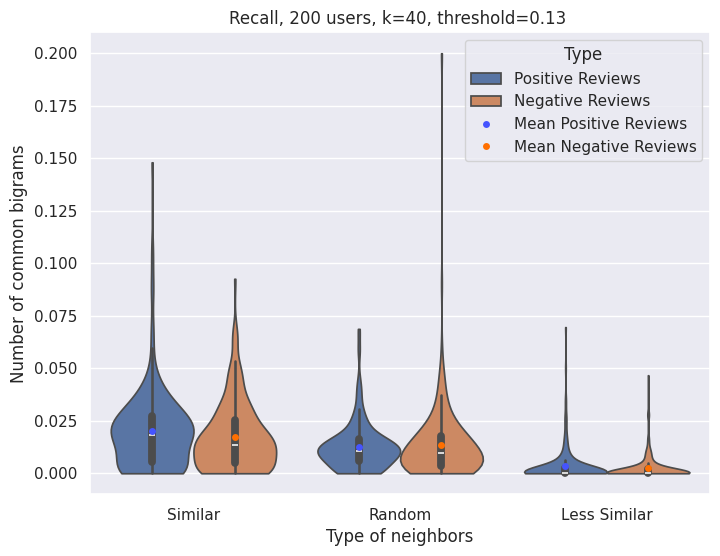

In [71]:
title = "Recall, 200 users, k=40, threshold=0.13 "
ylab = "Number of common bigrams"
xlab = "Type of neighbors"

df_pos_neg, group_mean = ebf.evaluate_big(ebf.knn_comments_ROUGE_v, 200, 5, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold=0.13, k=40)
ebf.plot_posnegviolin(df_pos_neg, group_mean, title, xlab, ylab, "vplot_recall_200.png")

#### Precision, intersection / neighbors number of bigrams

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


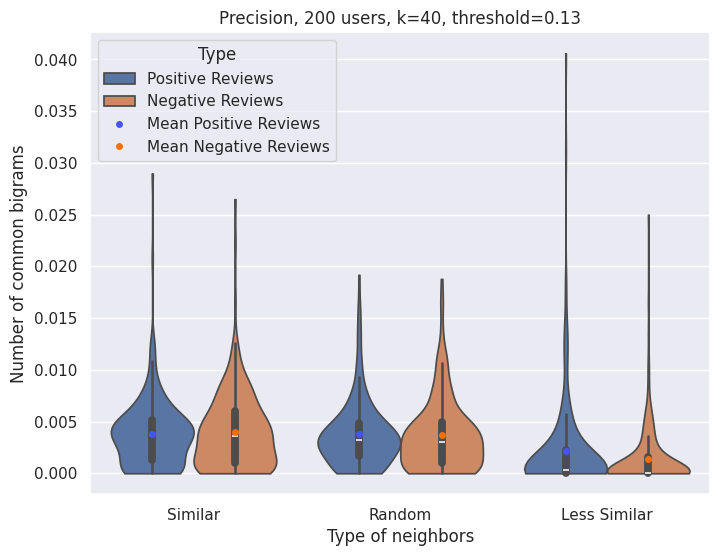

In [72]:
title = "Precision, 200 users, k=40, threshold=0.13"
ylab = "Number of common bigrams"
xlab = "Type of neighbors"

df_pos_neg, group_mean = ebf.evaluate_big(ebf.knn_comments_BLEU_v, 200, 5, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold=0.13, k=40)
ebf.plot_posnegviolin(df_pos_neg, group_mean, title, xlab, ylab, "vplot_precision_200.png")

#### Count number of bigrams in the intersection in average (per game)

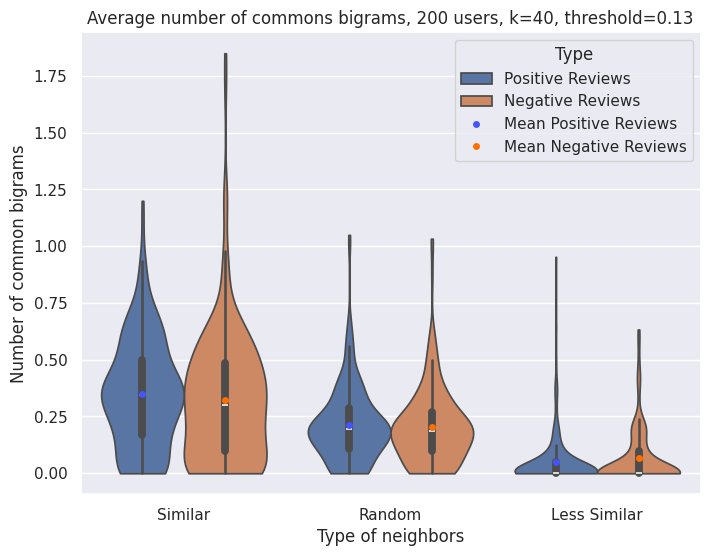

In [70]:
title = "Average number of commons bigrams, 200 users, k=40, threshold=0.13"
ylab = "Number of common bigrams"
xlab = "Type of neighbors"

df_pos_neg, group_mean = ebf.evaluate_big(ebf.knn_comments_count_v, 200, 5, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold=0.13, k=40)
ebf.plot_posnegviolin(df_pos_neg, group_mean, title, xlab, ylab, "vplot_common_big_count_200.png")

---
#### Second version, test on choice of neighbors 

In [93]:
n_users = 200
nb_iters = 5

users_ids_samp = comments_all.sample(n=n_users)['User id']

avg_pos_s = []
avg_neg_s = []
avg_pos_ls = []
avg_neg_ls = []
avg_pos_r = []
avg_neg_r = []

for _ in range(nb_iters):
    for id in users_ids_samp:
        neg_s, pos_s, neg_ls, pos_ls, neg_r, pos_r = ebf.knn_comments_count_v_bis(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold = 0.13, k = 40)
        
        avg_pos_s.append(pos_s)
        avg_neg_s.append(neg_s)

        avg_pos_ls.append(pos_ls)
        avg_neg_ls.append(neg_ls)

        avg_pos_r.append(pos_r)
        avg_neg_r.append(neg_r)

lst_l = ebf.lst_avg([avg_pos_s, avg_pos_r, avg_pos_ls, avg_neg_s, avg_neg_r, avg_neg_ls], nb_iters, n_users)

df_pos_neg = ebf.type_user_count_df(*lst_l)
group_means = ebf.df_user_type_mean(df_pos_neg)

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


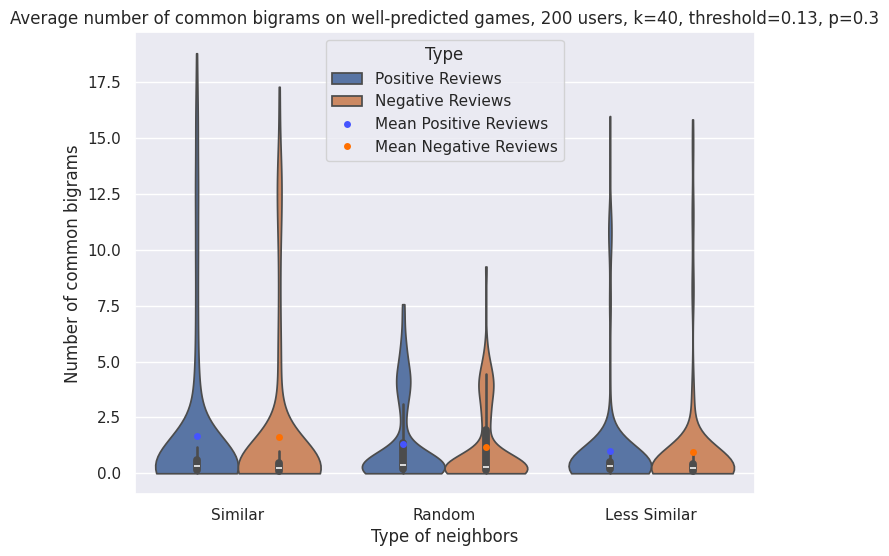

In [97]:
title = "Average number of common bigrams on well-predicted games, 200 users, k=40, threshold=0.13, p=0.3"
ylab = "Number of common bigrams"
xlab = "Type of neighbors"

# df_pos_neg, group_mean = ebf.evaluate_big(ebf.knn_comments_count_v, 200, 5, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold=0.13, k=40)
ebf.plot_posnegviolin(df_pos_neg, group_means, title, xlab, ylab, "vplot_common_big_avg_v2.png")

In [103]:
n_users = 200
nb_iters = 5

users_ids_samp = comments_all.sample(n=n_users)['User id']

avg_pos_s = []
avg_neg_s = []
avg_pos_ls = []
avg_neg_ls = []
avg_pos_r = []
avg_neg_r = []

for _ in range(nb_iters):
    for id in users_ids_samp:
        neg_s, pos_s, neg_ls, pos_ls, neg_r, pos_r = ebf.knn_comments_ROUGE_v_bis(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold = 0.13, k = 40)
        
        avg_pos_s.append(pos_s)
        avg_neg_s.append(neg_s)

        avg_pos_ls.append(pos_ls)
        avg_neg_ls.append(neg_ls)

        avg_pos_r.append(pos_r)
        avg_neg_r.append(neg_r)

lst_l = ebf.lst_avg([avg_pos_s, avg_pos_r, avg_pos_ls, avg_neg_s, avg_neg_r, avg_neg_ls], nb_iters, n_users)

df_pos_neg = ebf.type_user_count_df(*lst_l)
group_means = ebf.df_user_type_mean(df_pos_neg)

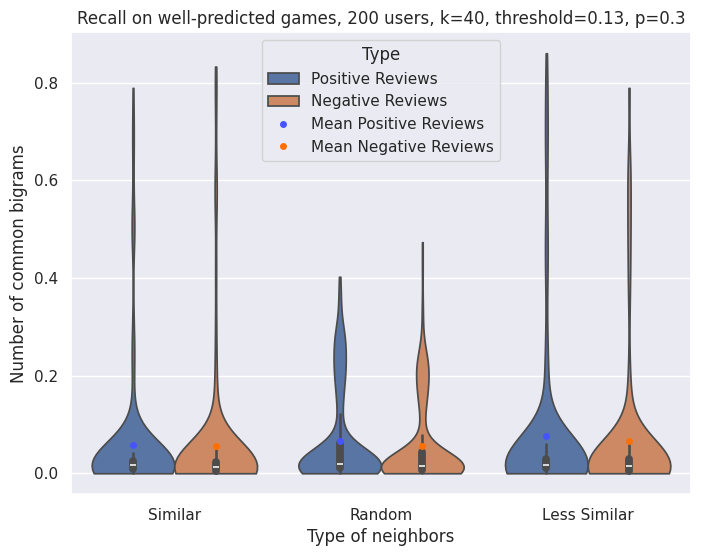

In [104]:
title = "Recall on well-predicted games, 200 users, k=40, threshold=0.13, p=0.3"
ylab = "Number of common bigrams"
xlab = "Type of neighbors"

# df_pos_neg, group_mean = ebf.evaluate_big(ebf.knn_comments_count_v, 200, 5, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold=0.13, k=40)
ebf.plot_posnegviolin(df_pos_neg, group_means, title, xlab, ylab, "vplot_recall_v2.png")

In [105]:
n_users = 200
nb_iters = 5

users_ids_samp = comments_all.sample(n=n_users)['User id']

avg_pos_s = []
avg_neg_s = []
avg_pos_ls = []
avg_neg_ls = []
avg_pos_r = []
avg_neg_r = []

for _ in range(nb_iters):
    for id in users_ids_samp:
        neg_s, pos_s, neg_ls, pos_ls, neg_r, pos_r = ebf.knn_comments_BLEU_v_bis(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold = 0.13, k = 40)
        
        avg_pos_s.append(pos_s)
        avg_neg_s.append(neg_s)

        avg_pos_ls.append(pos_ls)
        avg_neg_ls.append(neg_ls)

        avg_pos_r.append(pos_r)
        avg_neg_r.append(neg_r)

lst_l = ebf.lst_avg([avg_pos_s, avg_pos_r, avg_pos_ls, avg_neg_s, avg_neg_r, avg_neg_ls], nb_iters, n_users)

df_pos_neg = ebf.type_user_count_df(*lst_l)
group_means = ebf.df_user_type_mean(df_pos_neg)

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


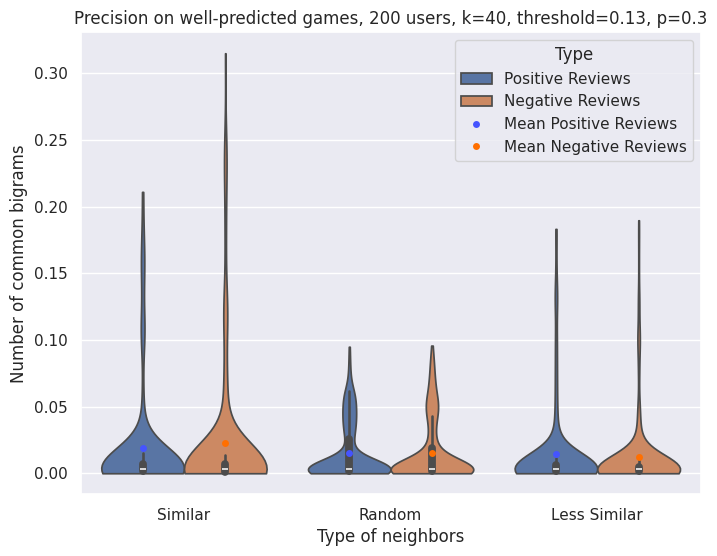

In [106]:
title = "Precision on well-predicted games, 200 users, k=40, threshold=0.13, p=0.3"
ylab = "Number of common bigrams"
xlab = "Type of neighbors"

# df_pos_neg, group_mean = ebf.evaluate_big(ebf.knn_comments_count_v, 200, 5, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, comments_all, users_mean, vectors, bigrams_ens, threshold=0.13, k=40)
ebf.plot_posnegviolin(df_pos_neg, group_means, title, xlab, ylab, "vplot_precision_v2.png")

---
